# Segmentation from Clustering Demo

## Set-up

### Load modules

In [1]:
import os # module for interacting with files and folders
from audio_processing import *
from audio_display import *
from array_manipulation import *
from load_audio import *
from feature_normalize import *
from pca_paths import *
from frame_clustering import *
from segments import *

### Load Audio Files

In [2]:
paths = [r'sound/American-English/Narrative',
        r'sound/American-English/Consonants',
        r'sound/American-English/Vowels',
        r'sound/Non-speech']

out_path = 'sound/out/'

fns,audio_data = load_audio(paths_list=paths, pad=0,nonspeech_dur=0)

narrative_fns,consonants_fns,vowels_fns,nonspeech_fns = fns
narrative_data,consonants_data,vowels_data,nonspeech_data = audio_data

### Normalization from Narrative Data

In [3]:
narr = get_narr(narrative_fns,pad=0)
narr_scaler = get_scaler(narrative_fns)

narr_frames = np.transpose(norm_array_hor(narr,narr_scaler))
print(narr_frames.shape)

narr_pca = PCA(n_components=3).fit(narr_frames)
narr_pcs = narr_pca.transform(narr_frames)
print(f'Explained variance ratio: \n{narr_pca.explained_variance_ratio_}')

(9549, 12)
Explained variance ratio: 
[0.27587196 0.17633568 0.15477869]


In [4]:
clip_dict = {}
path_test_fns = vowels_fns+consonants_fns+nonspeech_fns
for clip_fn in path_test_fns:
  name = clip_fn.split("/")[-1].split(".")[0].title()
  clip_data = process_audio(clip_fn,n_mfcc_list=[12],pad = 0)
  fourier = clip_data["fourier"]
  sr = clip_data["sr"]
  normed_mfcc = norm_array_hor(clip_data["mfcc"]["12"],narr_scaler)
  clip_frames = np.transpose(normed_mfcc)
  clip_pca = narr_pca.transform(clip_frames)
  clip_dict[name] = {"frames":clip_frames,"pca":clip_pca}

print(clip_dict.keys())
print(clip_dict["Bird"].keys())
print(clip_dict["Bird"]['frames'].shape)
print(clip_dict["Bird"]['pca'].shape)

dict_keys(['Bird', 'Bed', 'Bid', 'Above', 'Bayed', 'Good', 'Buy', 'Bud', 'Bead', 'Bough', 'Bad', 'Boy', 'Booed', 'Bode', 'Pod', 'Sigh', 'Shy', 'Fie', 'Rye', 'Die', 'Why', 'Hang', 'Guy', 'Thigh', 'You', 'Thy', 'Gin', 'Vie', 'My', 'Azure', 'Tie', 'High', 'Pie', 'Kite', 'Chin', 'Lie', 'Nigh', 'Zoo', 'Train', 'Water'])
dict_keys(['frames', 'pca'])
(202, 12)
(202, 3)


## Segmentation

### Even Segmentation

Sample rate = 22050
Frame Width = 2.902 ms
Clip length = 0.67 s
Number of segments: 7
[0.0,0.099]: 0
[0.099,0.2]: 0
[0.2,0.299]: 0
[0.299,0.401]: 0
[0.401,0.499]: 0
[0.499,0.601]: 0
[0.601,0.67]: 0


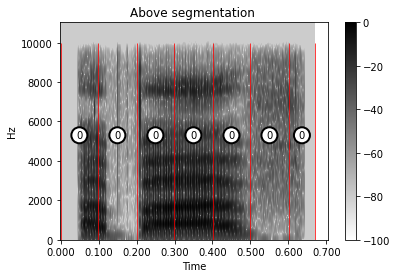

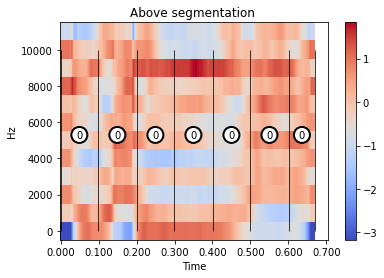

In [5]:
word = "Above"

data = [item for sublist in audio_data for item in sublist]
word_data = next(item for item in data if item["fn"].split("/")[-1].split(".")[0].title() == word)

res = 3
sr = sr
hop = 2**(9-res)
w = hop/sr

clip_len = clip_dict[word]["frames"].shape[0]

sig_figs = 3

print(f"Sample rate = {sr}")
print(f"Frame Width = {round(1000*w,sig_figs)} ms")
print(f"Clip length = {round(w*clip_len,sig_figs)} s")
even_segmentation = get_even_segments(clip_len,frame_w=w,seg_ms=100)
print(f"Number of segments: {len(even_segmentation)}")
for interval in even_segmentation:
    print(f'[{round(interval["tmin"],sig_figs)},{round(interval["tmax"],sig_figs)}]: {interval["text"]}')

#plot_timeseries_on_spectrogram(word_data["fourier"],y_pred,sr,scale_ts=1,title=f"{word} segmentation ",line_color='red')
#plot_timeseries_on_mfcc(np.transpose(clip_dict[word]['frames']),y_pred,sr,scale_ts=1,title=f"{word} segmentation ",line_color='black')
plot_segments_on_spectrogram(word_data["fourier"],even_segmentation,sr,title=f"{word} segmentation ",line_color='red')
plot_segments_on_mfcc(np.transpose(clip_dict[word]['frames']),even_segmentation,sr,title=f"{word} segmentation ",line_color='black')

### Refining a Segmentation

[{'fmin': 0, 'fmax': 231, 'tmin': 0.0, 'tmax': 0.6704761904761904, 'text': '0'}]
[{'fmin': 0, 'fmax': 100, 'tmin': 0.0, 'tmax': 0.29024943310657597, 'text': '00'}, {'fmin': 100, 'fmax': 231, 'tmin': 0.29024943310657597, 'tmax': 0.6704761904761904, 'text': '01'}]
[{'fmin': 0, 'fmax': 25, 'tmin': 0.0, 'tmax': 0.07256235827664399, 'text': '000'}, {'fmin': 25, 'fmax': 50, 'tmin': 0.07256235827664399, 'tmax': 0.14512471655328799, 'text': '001'}, {'fmin': 50, 'fmax': 100, 'tmin': 0.14512471655328799, 'tmax': 0.29024943310657597, 'text': '002'}, {'fmin': 100, 'fmax': 150, 'tmin': 0.29024943310657597, 'tmax': 0.43537414965986393, 'text': '010'}, {'fmin': 150, 'fmax': 231, 'tmin': 0.43537414965986393, 'tmax': 0.6704761904761904, 'text': '011'}]


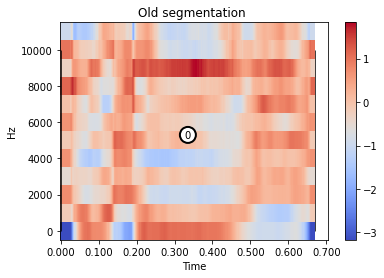

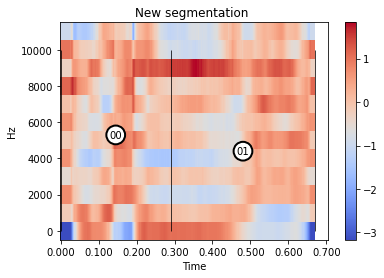

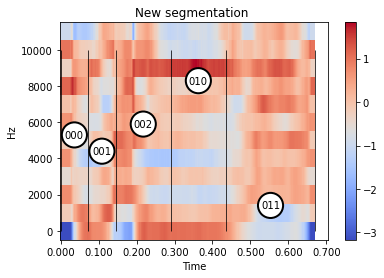

In [6]:
### Refining a Segmentation
word = "Above"
word_frames = clip_dict[word]["frames"]

seg = get_even_segments(word_frames.shape[0],w,n_segments=1)
print(seg)
refined_seg = refine_segmentation(seg,[100])
print(refined_seg)
refined_seg2 = refine_segmentation(refined_seg,[25,50,150])
print(refined_seg2)

plot_segments_on_mfcc(np.transpose(word_frames),seg,sr,title=f"Old segmentation ",line_color='black')
plot_segments_on_mfcc(np.transpose(word_frames),refined_seg,sr,title=f"New segmentation ",line_color='black')
plot_segments_on_mfcc(np.transpose(word_frames),refined_seg2,sr,title=f"New segmentation ",line_color='black')



### Pruning a Segmentation

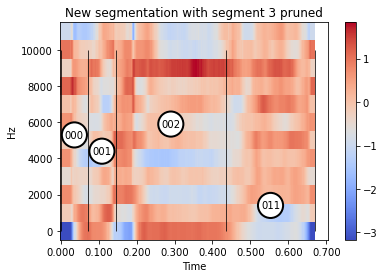

In [14]:
prune_ind = 2
pruned_seg = prune_segmentation(refined_seg2,prune_ind,text_method='first')
plot_segments_on_mfcc(np.transpose(word_frames),pruned_seg,sr,title=f"New segmentation with segment {prune_ind+1} pruned",line_color='black')

### From Clustering

#### Generate Clustering

In [8]:
word = "Above"

common_params = {"linkage": "complete",
    "distance_threshold": 18,
    "affinity": "manhattan",
    "connectivity": None,
    "compute_full_tree": True,
    "n_clusters": None,
}


X_combined = np.concatenate([clip_dict[word]["frames"],narr_frames],axis=0)
X_combined_pca = np.concatenate([clip_dict[word]["pca"],narr_pcs],axis=0)




data = [item for sublist in audio_data for item in sublist]
word_data = next(item for item in data if item["fn"].split("/")[-1].split(".")[0].title() == word)



agg_clusters_clip = AgglomerativeClustering(**common_params)
y_pred_combined = agg_clusters_clip.fit_predict(X_combined)

clip_len = clip_dict[word]["frames"].shape[0]

y_pred = np.split(y_pred_combined,[clip_len])[0]
X_pca = np.split(X_combined_pca,[clip_len])[0]


#### Get Segmentation

Sample rate = 22050
Frame Width = 2.902 ms
Clip length = 0.67 s
Number of segments: 10
[0.0,0.044]: 2
[0.044,0.131]: 3
[0.131,0.136]: 2
[0.136,0.148]: 1
[0.148,0.197]: 2
[0.197,0.206]: 1
[0.206,0.435]: 3
[0.435,0.488]: 0
[0.488,0.644]: 1
[0.644,0.67]: 2


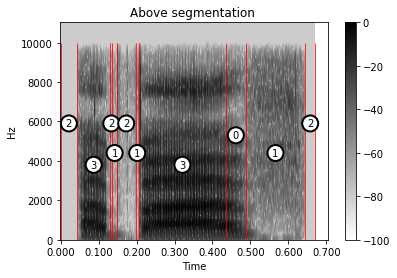

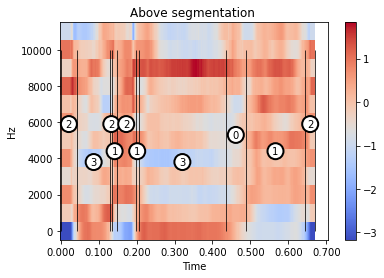

In [9]:
clustering = list(y_pred)

res = 3
sr = sr
hop = 2**(9-res)
w = hop/sr

sig_figs = 3

print(f"Sample rate = {sr}")
print(f"Frame Width = {round(1000*w,sig_figs)} ms")
print(f"Clip length = {round(w*clip_len,sig_figs)} s")
segmentation = get_intervals(clustering,frame_w=w)
print(f"Number of segments: {len(segmentation)}")
for interval in segmentation:
    print(f'[{round(interval["tmin"],sig_figs)},{round(interval["tmax"],sig_figs)}]: {interval["text"]}')

#plot_timeseries_on_spectrogram(word_data["fourier"],y_pred,sr,scale_ts=1,title=f"{word} segmentation ",line_color='red')
#plot_timeseries_on_mfcc(np.transpose(clip_dict[word]['frames']),y_pred,sr,scale_ts=1,title=f"{word} segmentation ",line_color='black')
plot_segments_on_spectrogram(word_data["fourier"],segmentation,sr,title=f"{word} segmentation ",line_color='red')
plot_segments_on_mfcc(np.transpose(clip_dict[word]['frames']),segmentation,sr,title=f"{word} segmentation ",line_color='black')

### Splitting frames

In [10]:
split_mfcc = split_frames(segmentation,clip_dict[word]['frames'])
split_fourier = split_frames(segmentation,np.transpose(word_data["fourier"]))

[0.0,0.044]: 2 (15, 12) (15, 1025)
[0.044,0.131]: 3 (30, 12) (30, 1025)
[0.131,0.136]: 2 (2, 12) (2, 1025)
[0.136,0.148]: 1 (4, 12) (4, 1025)
[0.148,0.197]: 2 (17, 12) (17, 1025)
[0.197,0.206]: 1 (3, 12) (3, 1025)
[0.206,0.435]: 3 (79, 12) (79, 1025)
[0.435,0.488]: 0 (18, 12) (18, 1025)
[0.488,0.644]: 1 (54, 12) (54, 1025)
[0.644,0.67]: 2 (9, 12) (9, 1025)


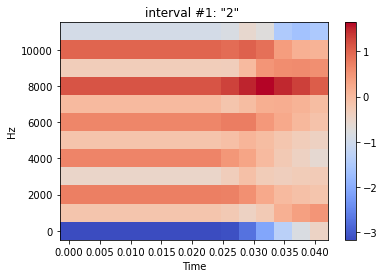

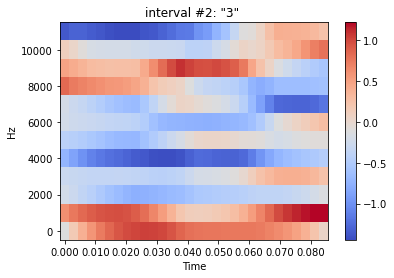

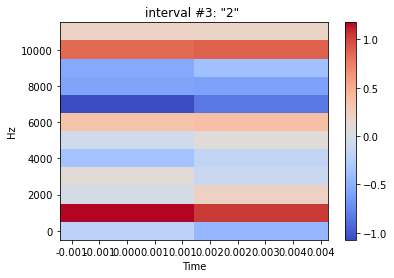

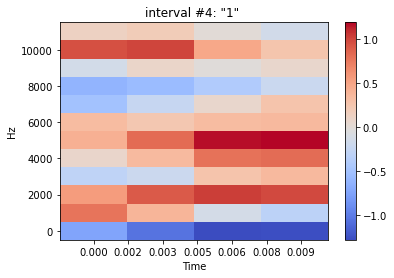

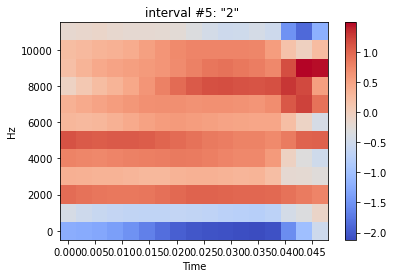

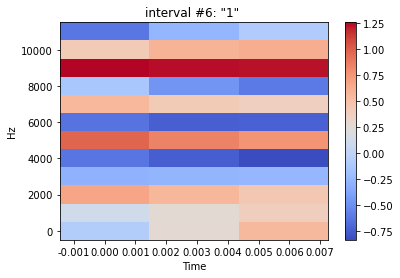

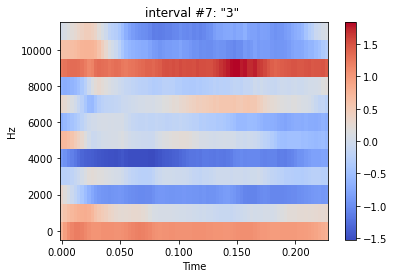

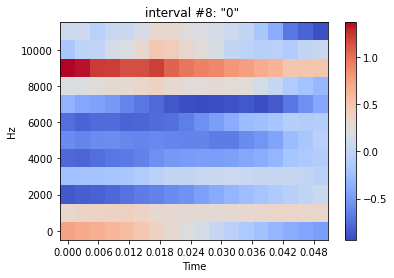

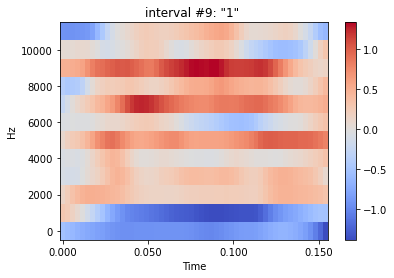

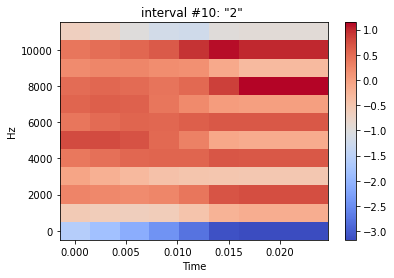

In [11]:
for interval,mfcc,fourier in zip(segmentation,split_mfcc,split_fourier):
    print(f'[{round(interval["tmin"],sig_figs)},{round(interval["tmax"],sig_figs)}]: {interval["text"]} {mfcc.shape} {fourier.shape}')

for i,(interval,mfcc) in enumerate(zip(segmentation,split_mfcc)):
    plot_mfcc(np.transpose(mfcc),title=f'interval #{i+1}: \"{interval["text"]}\" ',sr= clip_data["sr"])

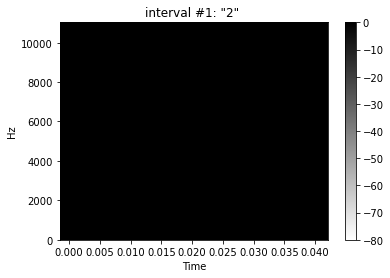

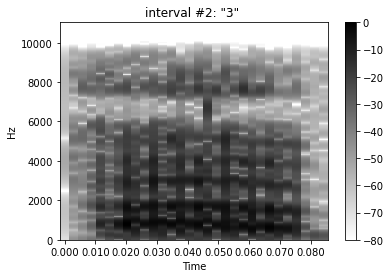

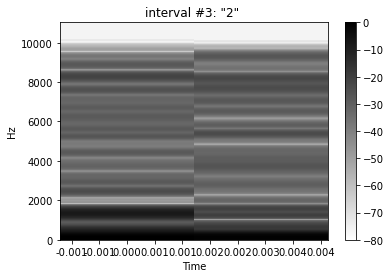

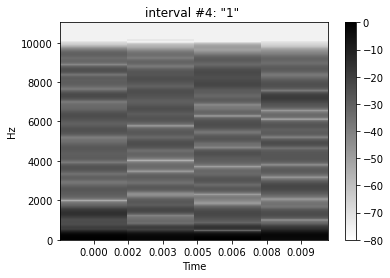

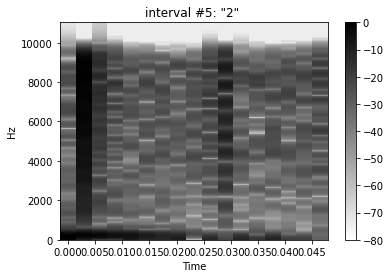

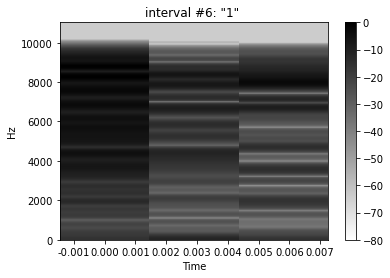

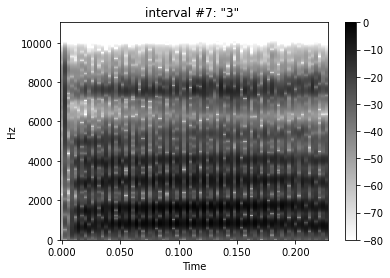

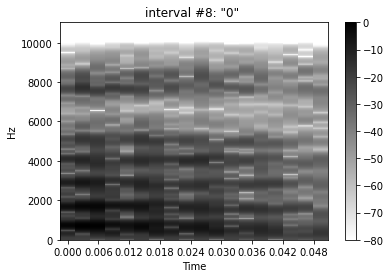

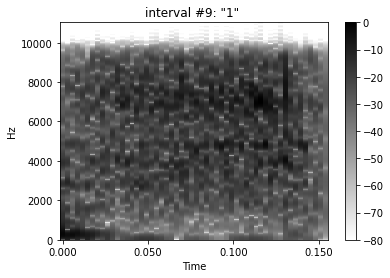

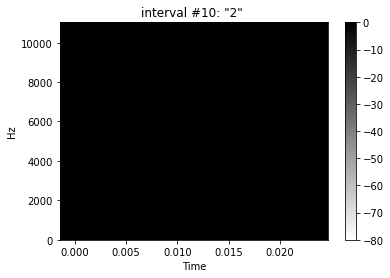

In [12]:
for i,(interval,fourier) in enumerate(zip(segmentation,split_fourier)):
    plot_spectrogram(np.transpose(fourier),title=f'interval #{i+1}: \"{interval["text"]}\" ',sr= clip_data["sr"])